# NBA Winner Classifier

## Imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_winner_clf as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy

## Setup

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 60 seconds


### Utils functions

In [23]:
def filter_from(items, cond):
    return list(filter(cond, items))

In [24]:
def del_result_by(exp_name):
    global results_total
    results_total = filter_from(results_total, lambda i: i[0] != exp_name)
    utils_exp.exp_results = filter_from(utils_exp.exp_results, lambda i: i['exp_name'] != exp_name)

In [25]:
def get_result_by(exp_name):
    global results_total
    return next((x for x in results_total if x[0] == exp_name), None)

In [25]:
#del_result_by('reg_1_season')
#utils_exp.exp_results
#utils.deserialize_object(f'result_totals', [])

In [26]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [27]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.lineplot(
        data=results_df,
        x="season_test", y="balanced_accuracy", hue="model", style="model",
        markers=True, dashes=False)
    a.set_title(
        f"{experiment_name}-balanced_accuracy")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [28]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [29]:
metrics = ['precision', 'balanced_accuracy', 'roc_auc']

def print_prettier_exp_results(exp_name, metric='roc_auc'):
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std']]
    return ba_df[ba_df.exp_name == exp_name].sort_values(by=[f"{metric}_mean"], ascending=False)

## Load Dataset

In [30]:
season_games = sg.load_season_games_dataset()

## Dataset


In [31]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [31]:
df = season_games[season_games.SEASON >= 2013]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

In [32]:
df.shape

(8439, 381)

In [33]:
#df = df.fillna(value=0)1
df = df.dropna()

In [34]:
df.isnull().sum().sum()

0

In [35]:
df.shape

(8324, 381)

## Experiments

### Setup

In [37]:
exp_prefix = "clf_"
exp_group_name = "clf_experiments"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = []
TARGET = "HOME_WINS"
exp_X_columns = model_config.X_COLS
exp_y_columns = model_config.Y_CLF_COL

models = utils_exp.get_clf_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

### Feature selection

In [18]:
def dict_to_list(d):
    dictlist = []
    for key, value in d.items():
        temp = [key,value]
        dictlist.append(temp)
    return pd.DataFrame(data=dictlist)

In [19]:
# instantiate random forest
from collections import defaultdict

model = models[4][1]

c_cols = sg.create_calculate_fields(df)
sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[c_cols]
y = df_sscv[TARGET]

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
folds_selected_features = defaultdict(int)
boruta_selector = BorutaPy(model, n_estimators = 200, random_state = 0)
for train_idx, test_idx in folds[:1]:    
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    y_true = y_test
    # fit boruta
    boruta_selector.fit(np.array(X_train), np.array(y_train))
    boruta_ranking = boruta_selector.ranking_
    selected_features = np.array(c_cols)[boruta_ranking <= 2]
    for f in selected_features:
        folds_selected_features[f]+=1
#dict_to_list(folds_selected_features)
# # store results
# boruta_ranking = boruta_selector.ranking_
# selected_features = np.array(feature_names)[boruta_ranking <= 2]

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7FDB0DD49C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7FDB0DD49C00)

In [20]:
f_df = dict_to_list(folds_selected_features)

In [21]:
f_df.sort_values(by=[1, 0], ascending=False)
final_selected_features = list(f_df[0].unique())

,0,1
4,HOME_W_L_CUM,2
3,HOME_PLUS_MINUS_MEAN,2
2,HOME_PLUS_MINUS_L10,2
1,HOME_FG_PCT_MEAN,2
0,HOME_FG3_PCT_MEAN,1


### Experiment using 1 season

In [39]:
experiment_name = f"{exp_prefix}1_season"

In [40]:
del_result_by(experiment_name)

#X = df_sscv[final_selected_features]
folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_1_season
Done


,exp_name,model,roc_auc_mean,roc_auc_std
3,clf_1_season,SVM,0.722249,0.012102
0,clf_1_season,LR,0.717606,0.016823
6,clf_1_season,LGB,0.713530,0.008201
5,clf_1_season,XGB,0.712591,0.007544
4,clf_1_season,RF,0.705037,0.010588
2,clf_1_season,DT,0.640019,0.014195
1,clf_1_season,KNN,0.626640,0.023329


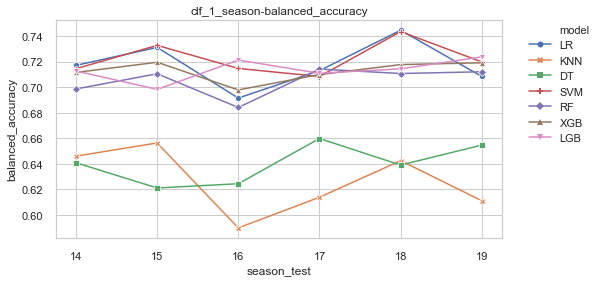

In [41]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment using StandardScaler

In [42]:
experiment_name = f"{exp_prefix}scaled_data"

In [43]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, model_config.X_COLS)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_scaled_data
Done


,exp_name,model,roc_auc_mean,roc_auc_std
7,clf_scaled_data,LR,0.723069,0.012610
10,clf_scaled_data,SVM,0.720553,0.011078
13,clf_scaled_data,LGB,0.714228,0.007847
12,clf_scaled_data,XGB,0.712520,0.007143
11,clf_scaled_data,RF,0.705533,0.011896
8,clf_scaled_data,KNN,0.643996,0.019470
9,clf_scaled_data,DT,0.640017,0.014131


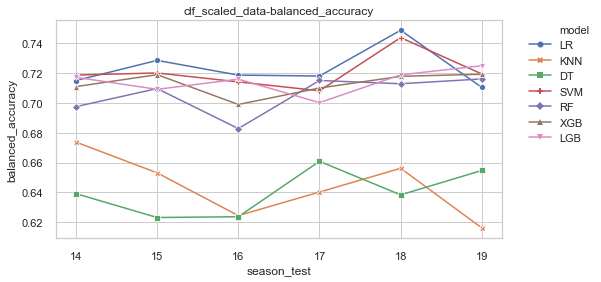

In [44]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))


### Experiment using MinMaxScaler

In [45]:
experiment_name = f"{exp_prefix}minmax_data"

In [46]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, model_config.X_COLS)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_minmax_data
Done


,exp_name,model,roc_auc_mean,roc_auc_std
17,clf_minmax_data,SVM,0.727994,0.013332
14,clf_minmax_data,LR,0.725329,0.015806
19,clf_minmax_data,XGB,0.712949,0.007545
20,clf_minmax_data,LGB,0.712336,0.004962
18,clf_minmax_data,RF,0.705978,0.010144
15,clf_minmax_data,KNN,0.655208,0.014441
16,clf_minmax_data,DT,0.640179,0.014189


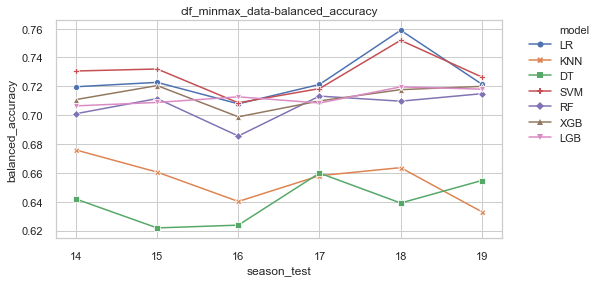

In [47]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment: train: 2s; test: 1s

In [48]:
experiment_name = f"{exp_prefix}2_seasons"

In [49]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons
Done


,exp_name,model,roc_auc_mean,roc_auc_std
21,clf_2_seasons,LR,0.730653,0.006159
24,clf_2_seasons,SVM,0.729696,0.013865
27,clf_2_seasons,LGB,0.719425,0.010529
26,clf_2_seasons,XGB,0.718525,0.008769
25,clf_2_seasons,RF,0.714051,0.013948
23,clf_2_seasons,DT,0.640385,0.012402
22,clf_2_seasons,KNN,0.616398,0.011318


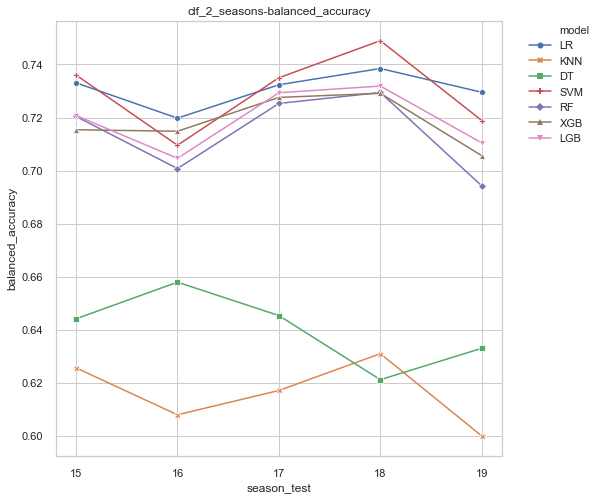

In [50]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,8))

### Experiment: train: 3s; test: 1s

In [51]:
experiment_name = f"{exp_prefix}3_seasons"

In [52]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3_seasons
Done


,exp_name,model,roc_auc_mean,roc_auc_std
31,clf_3_seasons,SVM,0.733751,0.013959
28,clf_3_seasons,LR,0.731651,0.012880
34,clf_3_seasons,LGB,0.723428,0.004678
32,clf_3_seasons,RF,0.717285,0.018972
33,clf_3_seasons,XGB,0.717058,0.009876
30,clf_3_seasons,DT,0.636232,0.009015
29,clf_3_seasons,KNN,0.618763,0.010385


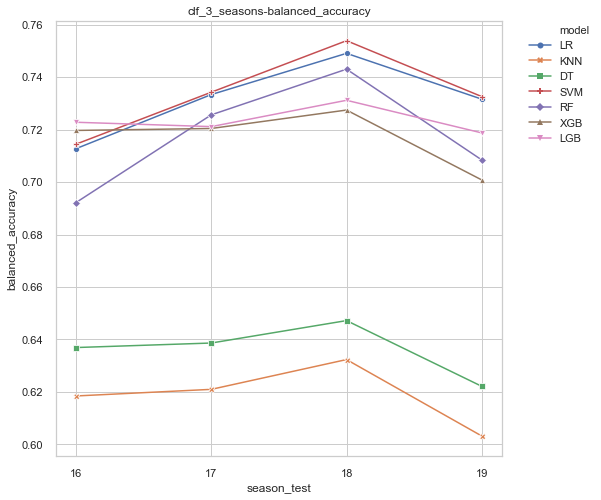

In [53]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,8))

### Experiment train: 3q ; test: 1q

In [54]:
experiment_name = f"{exp_prefix}3q_1q"

In [55]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3q_1q
Done


,exp_name,model,roc_auc_mean,roc_auc_std
38,clf_3q_1q,SVM,0.715734,0.024066
35,clf_3q_1q,LR,0.714640,0.024530
41,clf_3q_1q,LGB,0.709879,0.032157
40,clf_3q_1q,XGB,0.709600,0.026459
39,clf_3q_1q,RF,0.700438,0.024809
37,clf_3q_1q,DT,0.649372,0.026692
36,clf_3q_1q,KNN,0.630286,0.027596


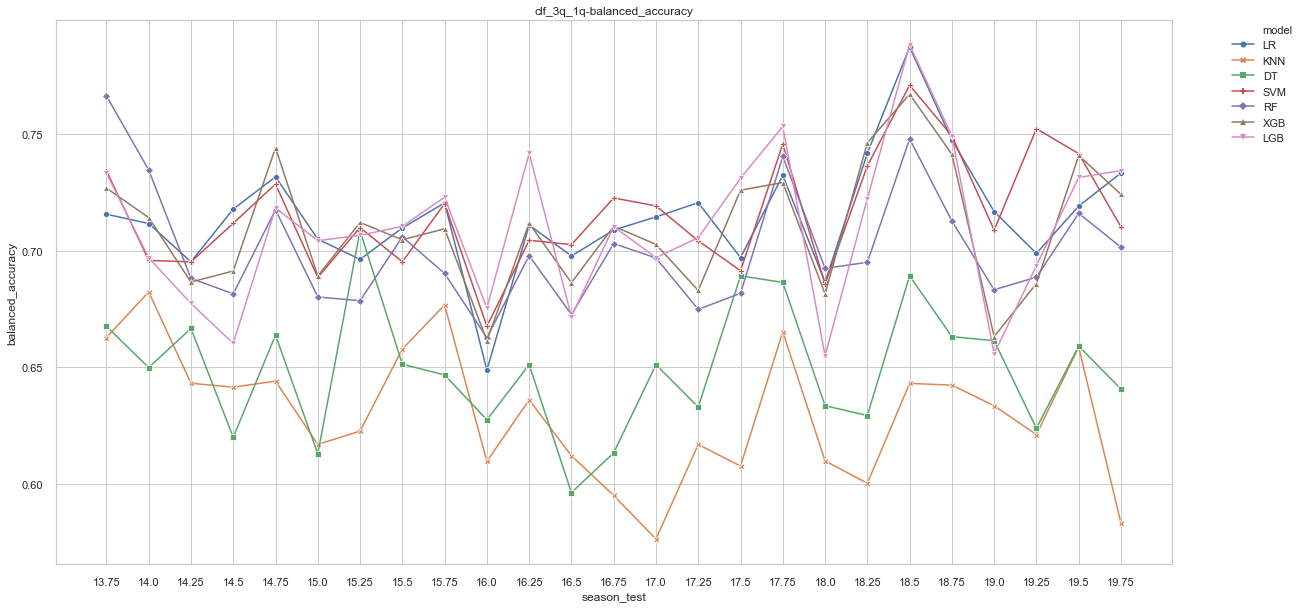

In [56]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(20, 10))

### Experiment train: 4q ; test: 2q

In [57]:
experiment_name = f"{exp_prefix}4q_2q"

In [58]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_4q_2q
Done


,exp_name,model,roc_auc_mean,roc_auc_std
45,clf_4q_2q,SVM,0.723751,0.017277
42,clf_4q_2q,LR,0.719397,0.014441
48,clf_4q_2q,LGB,0.716219,0.017194
47,clf_4q_2q,XGB,0.715493,0.012557
46,clf_4q_2q,RF,0.704545,0.012966
44,clf_4q_2q,DT,0.643332,0.018707
43,clf_4q_2q,KNN,0.626214,0.020531


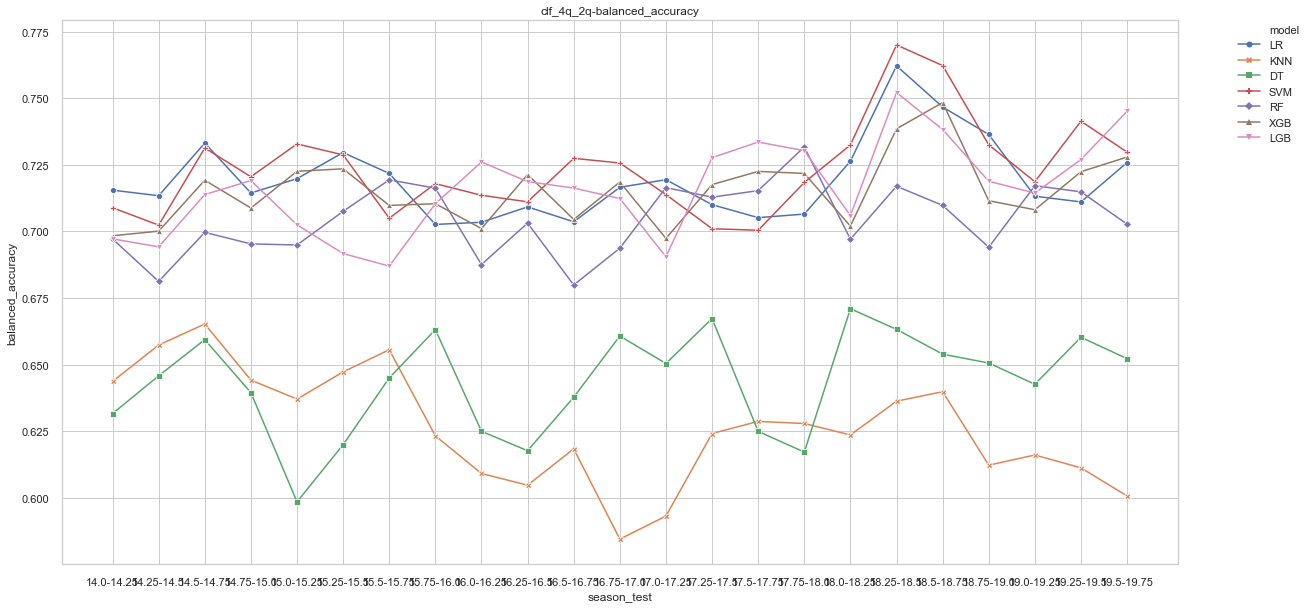

In [59]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(20,10))

### Experiment remove first 1q ; train: 2q ; test: 1q

En este experimento se eliminara el primer cuarto de cada temporada, y se entrenara el modelo con los 2 siguientes cuartos, y como test 1 cuarto de temporada. La ventana deslisante sera de 1 cuarto.

In [60]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

In [61]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=1, skip=[0.25])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_r1q_2q_1q
Done


,exp_name,model,roc_auc_mean,roc_auc_std
54,clf_r1q_2q_1q,XGB,0.716091,0.021438
55,clf_r1q_2q_1q,LGB,0.715369,0.030018
52,clf_r1q_2q_1q,SVM,0.714732,0.027007
49,clf_r1q_2q_1q,LR,0.713307,0.027182
53,clf_r1q_2q_1q,RF,0.700751,0.027658
51,clf_r1q_2q_1q,DT,0.649377,0.025648
50,clf_r1q_2q_1q,KNN,0.628506,0.028387


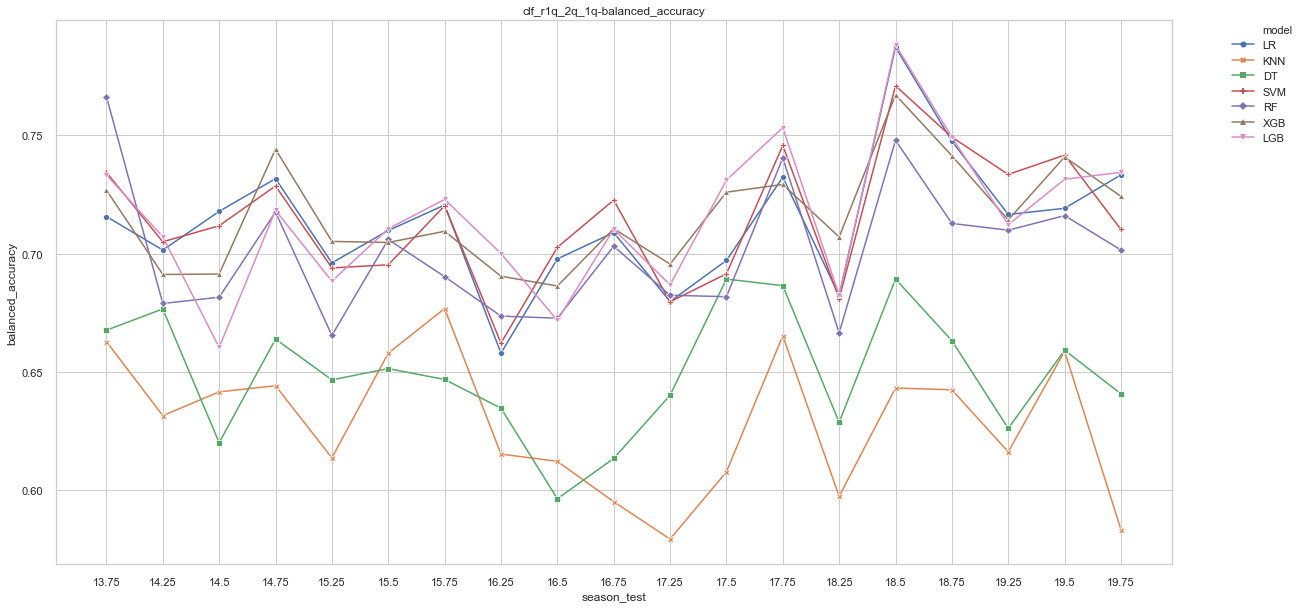

In [62]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(20,10))

### Experiments comparison

In [63]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [64]:
utils_exp.exp_results = utils.deserialize_object(exp_group_name)
exp_df = get_results_df()

In [65]:
ba_df = exp_df[['exp_name', 'model',
       'balanced_accuracy_mean', 'balanced_accuracy_std']]

In [66]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [67]:
ba_df.sort_values(
    by=["balanced_accuracy_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
0,clf_3_seasons,SVM,0.733751,0.013959
1,clf_3_seasons,LR,0.731651,0.012880
2,clf_2_seasons,LR,0.730653,0.006159
3,clf_2_seasons,SVM,0.729696,0.013865
4,clf_minmax_data,SVM,0.727994,0.013332
5,clf_minmax_data,LR,0.725329,0.015806


### Plot experiment results

In [68]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### Balance Accuracy

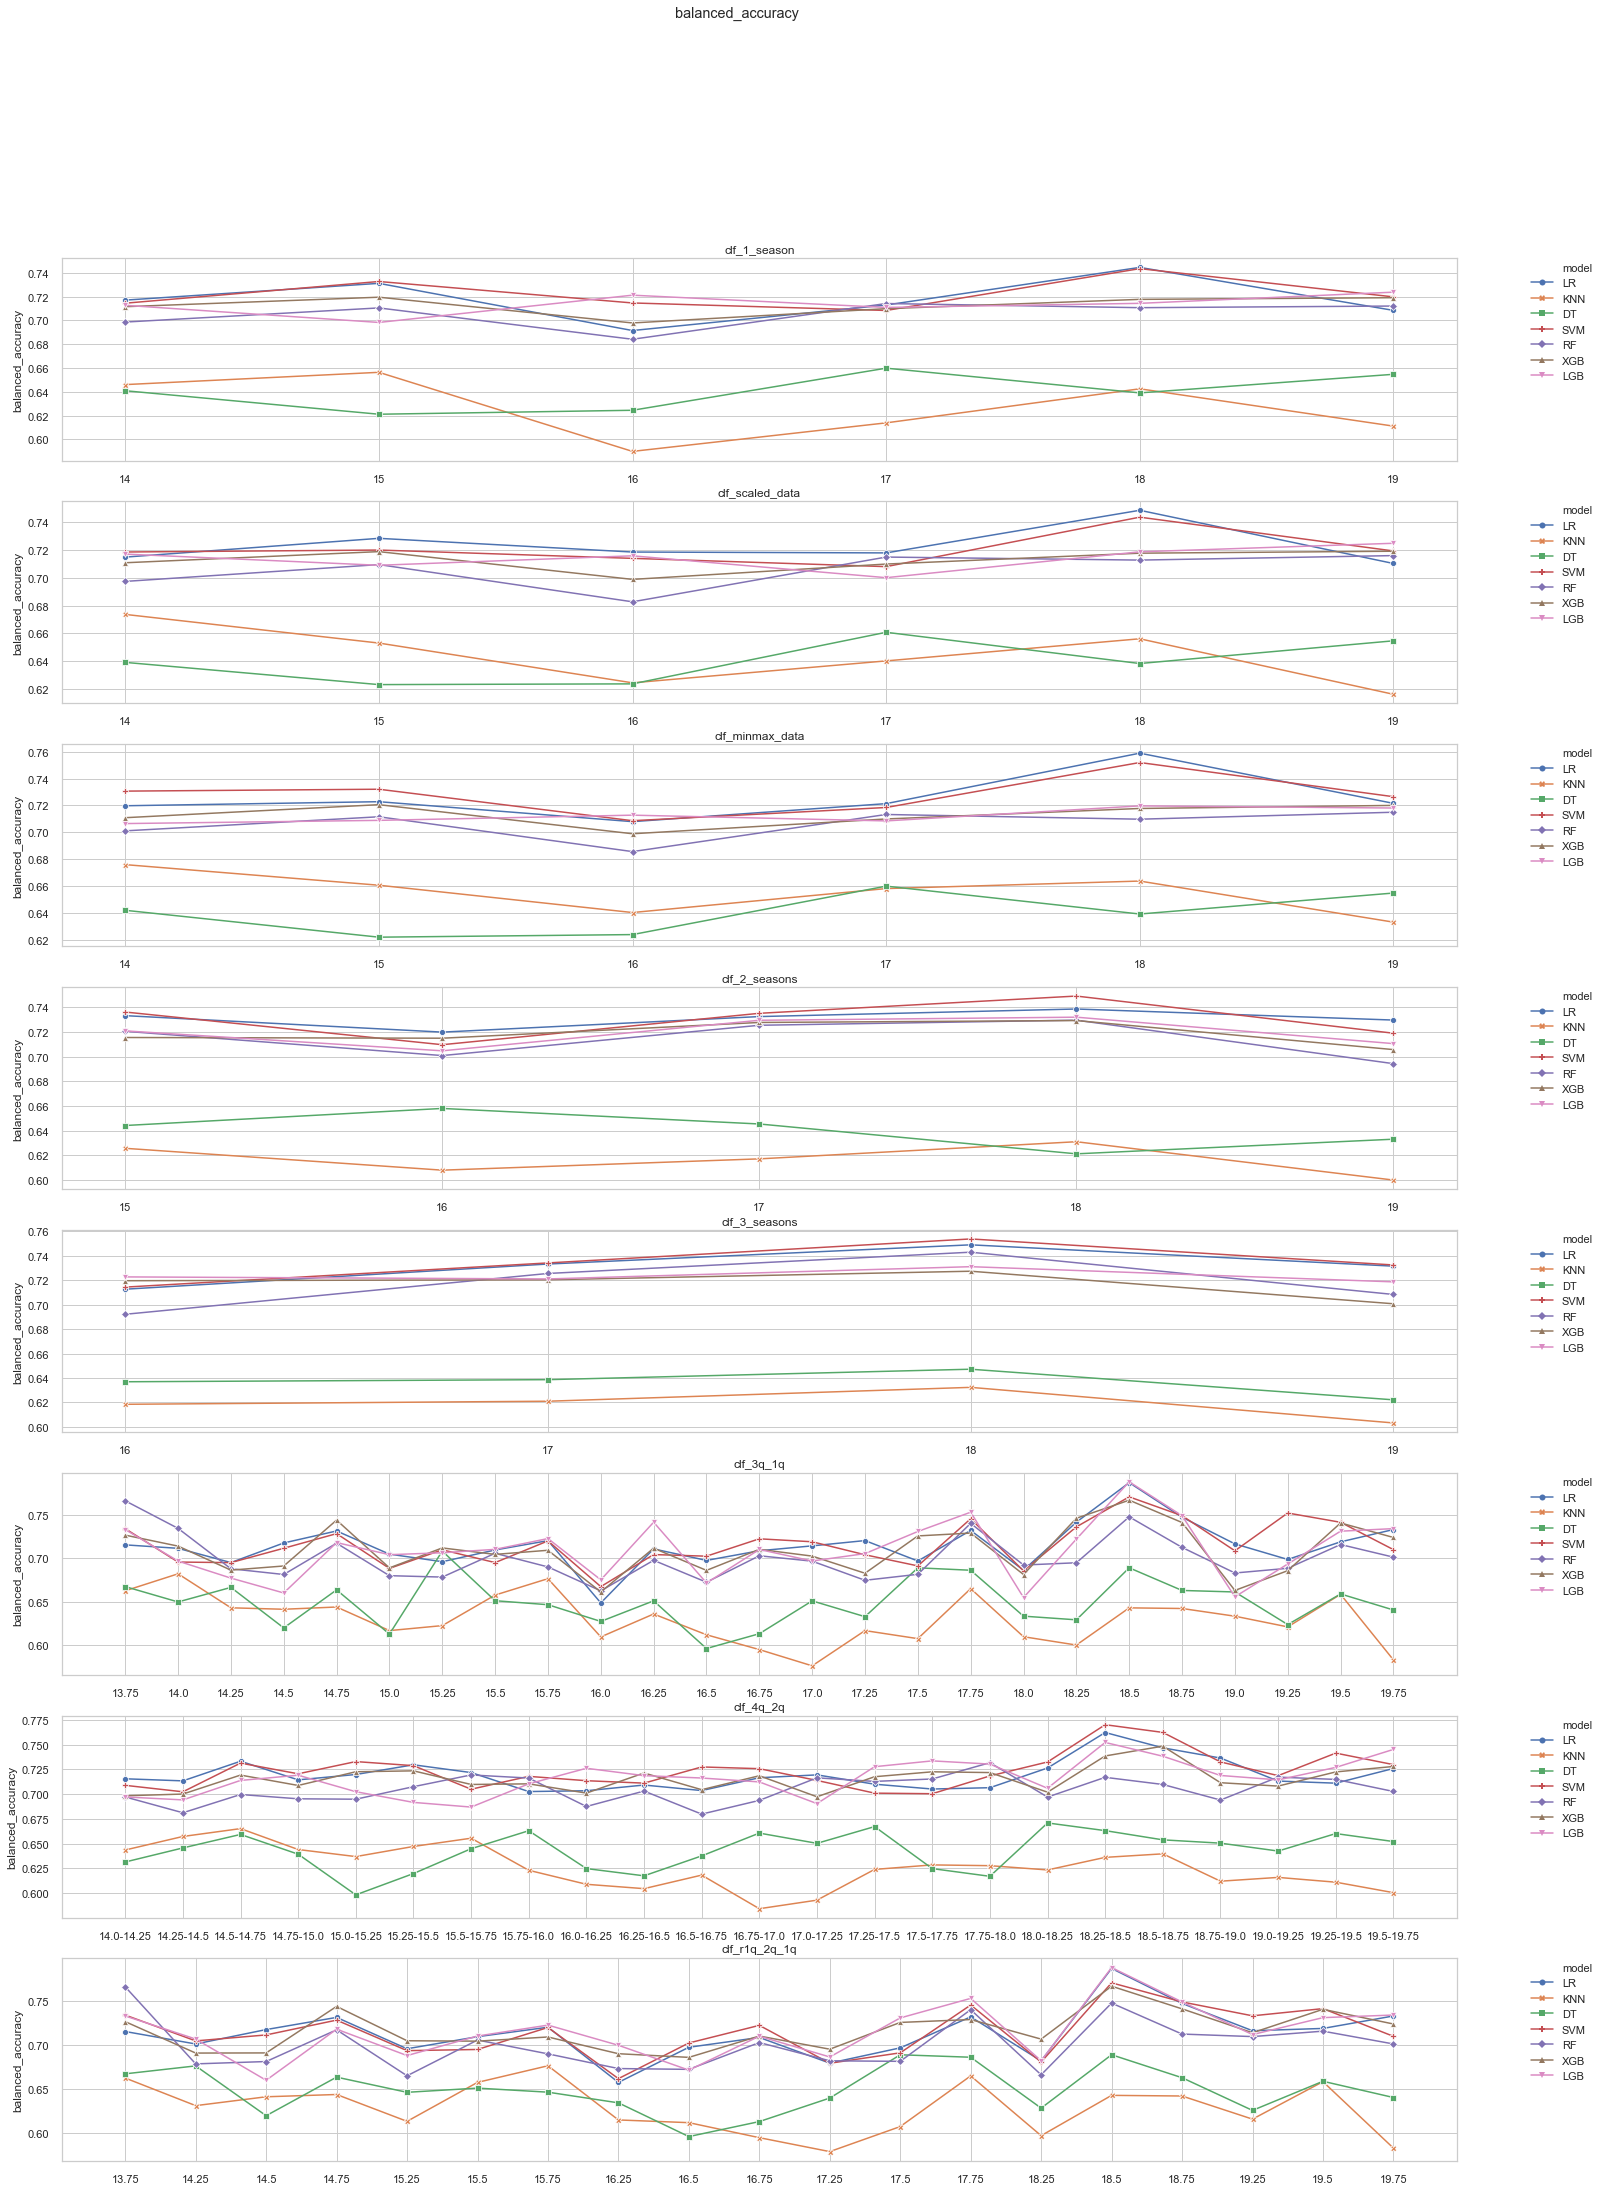

In [69]:
utils.plot_to_compare_experiments(
    results_total,
    metric="balanced_accuracy",
    figsize=(25, 35),
    use_pointplot=True
)

#### Precision

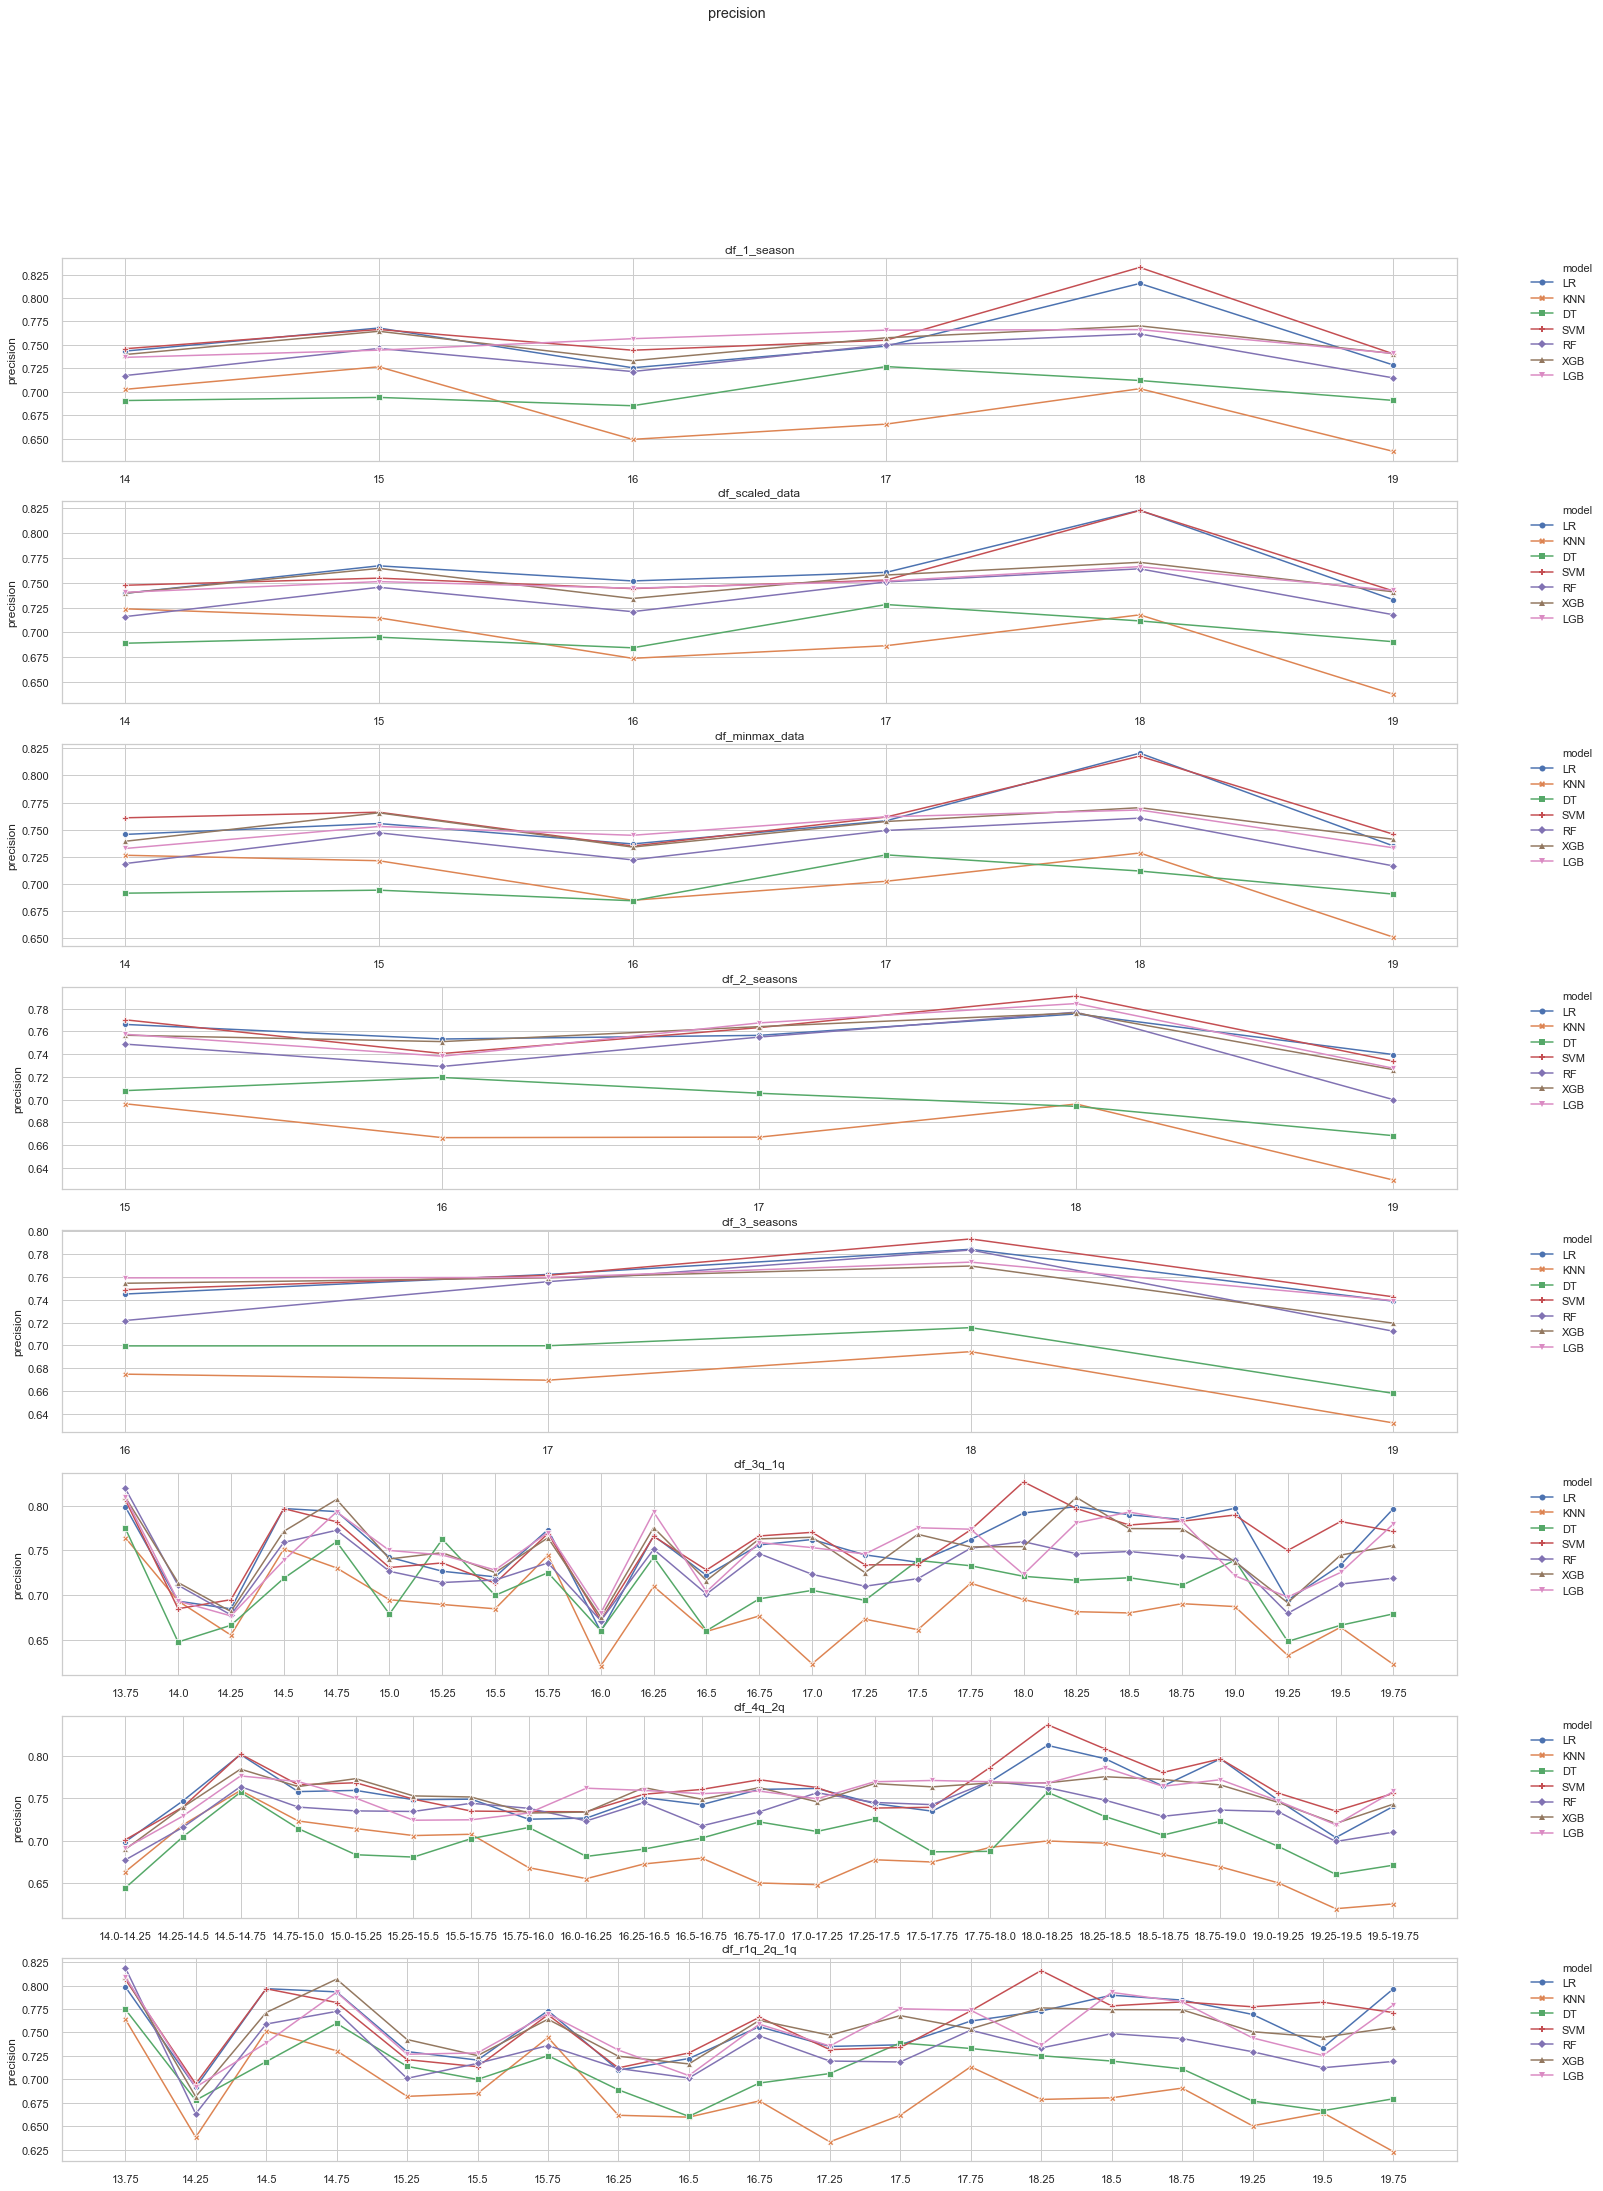

In [70]:
utils.plot_to_compare_experiments(
    results_total,
    metric="precision",
    figsize=(25, 35),
    use_pointplot=True
)

#### ROC AUC

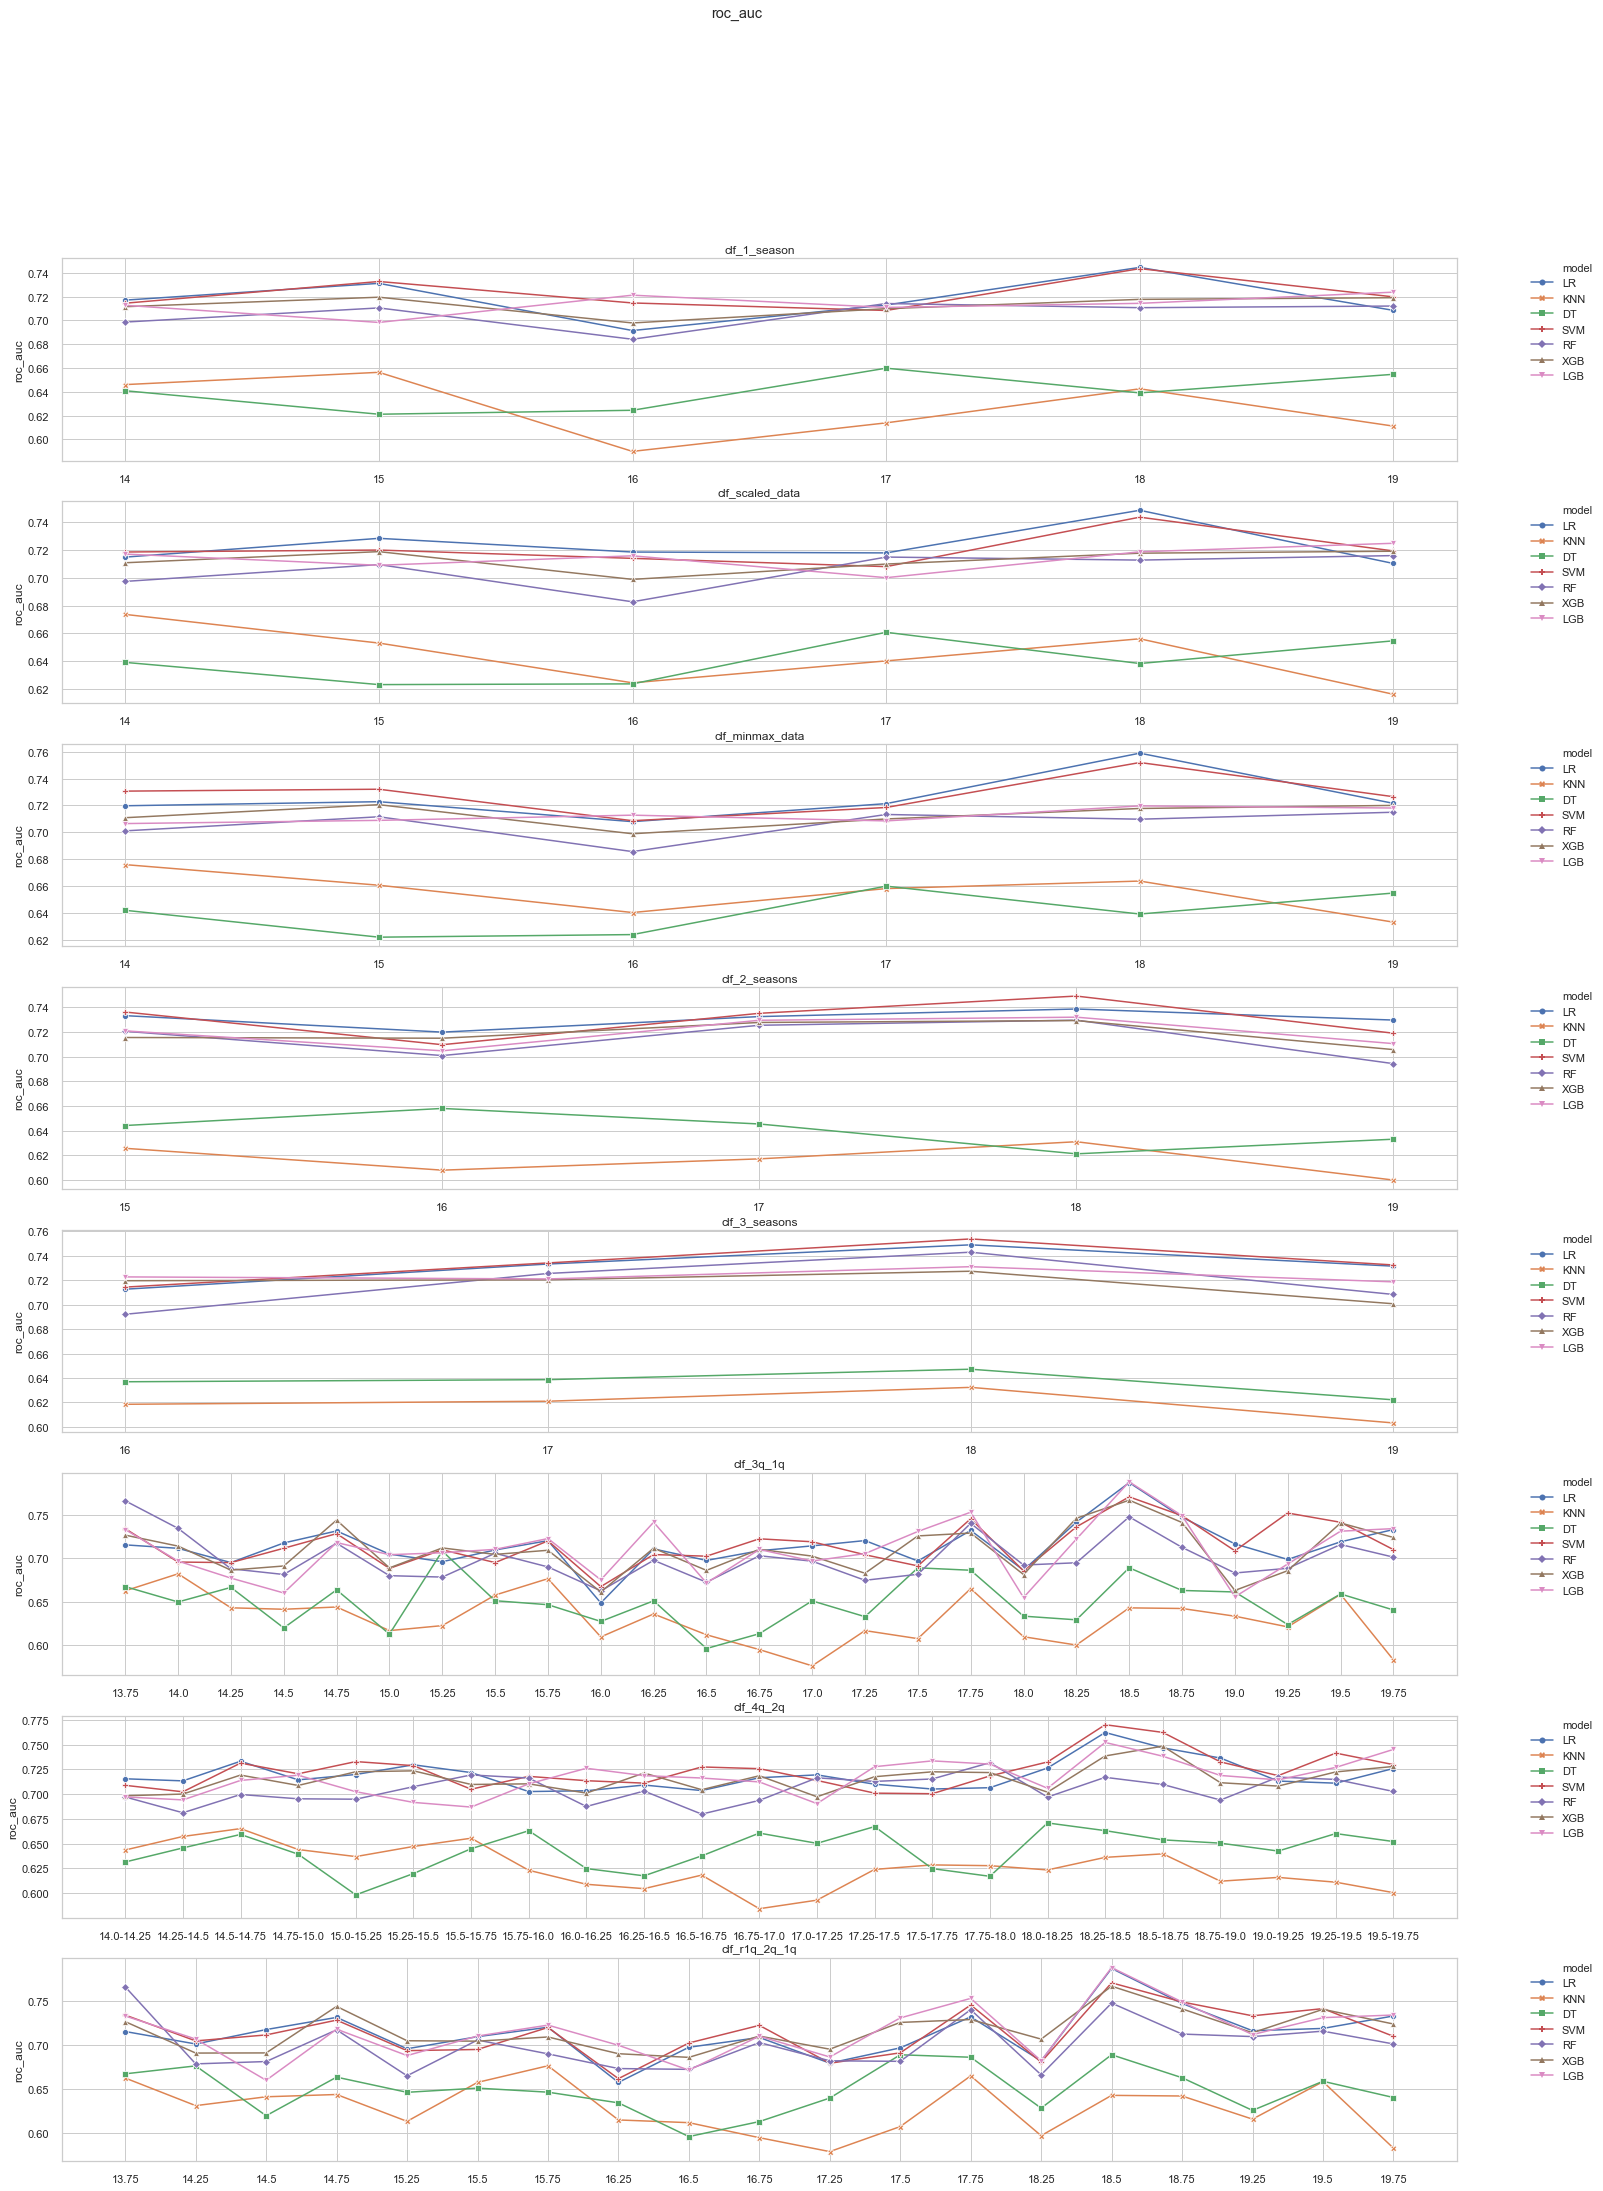

In [71]:
utils.plot_to_compare_experiments(
    results_total,
    metric="roc_auc",
    figsize=(25, 35),
    use_pointplot=True
)